In [1]:
!git clone https://github.com/ZHZisZZ/dllm.git
!pip install -e ./dllm

Cloning into 'dllm'...
remote: Enumerating objects: 1420, done.
remote: Counting objects: 100% (667/667), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 1420 (delta 477), reused 316 (delta 310), pack-reused 753 (from 1)
Receiving objects: 100% (1420/1420), 25.15 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (846/846), done.
Obtaining file:///content/dllm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: Error in the setup causing installation issues
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 

In [2]:
# Imports
import torch
from transformers import Qwen2Config, Qwen2ForCausalLM
from datasets import load_dataset


from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from transformers import PreTrainedTokenizerFast

import torch
from transformers import Qwen2Config, Qwen2ForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import DatasetDict


In [3]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")
train_raw = ds["train"].select(range(200_000))
eval_raw  = ds["validation"].select(range(10_000))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [4]:
def batch_iterator(dataset, batch_size=1000):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i+batch_size]["text"]

special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>", "<|mask|>"]

tok = Tokenizer(BPE(unk_token="<unk>"))
tok.pre_tokenizer = ByteLevel(add_prefix_space=True)
tok.decoder = ByteLevelDecoder()

trainer = BpeTrainer(vocab_size=32000, min_frequency=2, special_tokens=special_tokens)
tok.train_from_iterator(batch_iterator(train_raw), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tok,
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<bos>",
    eos_token="<eos>",
    mask_token="<|mask|>",
)

tokenizer.save_pretrained("./models/ar_qwen2_50m")
print("vocab:", tokenizer.vocab_size, "mask_token_id:", tokenizer.mask_token_id)

vocab: 31753 mask_token_id: 4


In [6]:
max_length = 256

def tok_fn(batch):
    out = tokenizer(
        batch["text"],
        add_special_tokens=False,
        return_attention_mask=False,
        return_token_type_ids=False,
    )
    return {"input_ids": out["input_ids"]}  # only keep input_ids

tok_ds = DatasetDict({
    "train": train_raw.map(tok_fn, batched=True, remove_columns=train_raw.column_names),
    "eval":  eval_raw.map(tok_fn, batched=True, remove_columns=eval_raw.column_names),
})

def group_texts(examples):
    ids = sum(examples["input_ids"], [])
    total_len = (len(ids) // max_length) * max_length
    ids = ids[:total_len]
    chunks = [ids[i:i+max_length] for i in range(0, total_len, max_length)]
    return {"input_ids": chunks, "labels": chunks.copy()}

lm_ds = DatasetDict({
    "train": tok_ds["train"].map(group_texts, batched=True, remove_columns=tok_ds["train"].column_names),
    "eval":  tok_ds["eval"].map(group_texts, batched=True, remove_columns=tok_ds["eval"].column_names),
})

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
# Model Config
config = Qwen2Config(
    # Reduced vocab to balance param count (unless you strictly need Qwen tokenizer)
    vocab_size= tokenizer.vocab_size,

    hidden_size=512,
    intermediate_size=1536, # 3x expansion
    num_hidden_layers=6,

    # Keeps head_dim = 128 (Critical for reproducing 7B math)
    num_attention_heads=4,
    num_key_value_heads=2,  # GQA ratio 2:1

    max_position_embeddings=1024,
    hidden_act="silu",

    # Modern Transformers usually accepts this at top-level
    rope_theta=10000.0,
)

# Initialize the model
model_ar = Qwen2ForCausalLM(config)


In [8]:
# Quick Param Check
embed_params = config.vocab_size * config.hidden_size
total_params = model_ar.num_parameters()
print(f"Total Params: {total_params:,}")
print(f"Embedding Params: {embed_params:,} ({embed_params/total_params:.1%} of total)")

Total Params: 51,402,240
Embedding Params: 16,257,536 (31.6% of total)


In [9]:
args = TrainingArguments(
    output_dir="./runs/ar_qwen2_50m_tinystories",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=3e-4,
    warmup_steps=200,
    max_steps=2000,
    logging_steps=20,
    eval_steps=200,
    save_steps=200,
    report_to="none",
)

collator_ar = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer_ar = Trainer(
    model=model_ar,
    args=args,
    train_dataset=lm_ds["train"],
    eval_dataset=lm_ds["eval"],
    data_collator=collator_ar,
)

trainer_ar.train()


Step,Training Loss
20,10.065800
40,8.914100
60,7.861300
80,6.565500
100,5.568200
120,4.908300
140,4.460000
160,4.069100
180,3.787100
200,3.609100


TrainOutput(global_step=2000, training_loss=2.6972220668792724, metrics={'train_runtime': 583.1048, 'train_samples_per_second': 219.515, 'train_steps_per_second': 3.43, 'total_flos': 6909729964032000.0, 'train_loss': 2.6972220668792724, 'epoch': 0.7507507507507507})

In [17]:
import os
os.makedirs("./models/ar_qwen2_50m", exist_ok=True)

model_ar.save_pretrained("./models/ar_qwen2_50m")   # this writes model.safetensors or pytorch_model.bin
tokenizer.save_pretrained("./models/ar_qwen2_50m")

('./models/ar_qwen2_50m/tokenizer_config.json',
 './models/ar_qwen2_50m/special_tokens_map.json',
 './models/ar_qwen2_50m/tokenizer.json')

In [13]:
!pip -q uninstall -y dllm || true
!pip -q install -e /content/dllm

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dllm (pyproject.toml) ... done


In [15]:
import sys, importlib

# Make sure python can see the repo package tree
sys.path.insert(0, "/content/dllm")

# If dllm was already imported from a different place, reload it
if "dllm" in sys.modules:
    import dllm
    importlib.reload(dllm)

import dllm
print("dllm from:", dllm.__file__)

dllm from: /content/dllm/dllm/__init__.py


In [18]:
import os, torch
import transformers
import dllm
from dllm.pipelines.a2d.models.qwen2.modeling_qwen2 import A2DQwen2Config

src_dir = "./models/ar_qwen2_50m"
out_dir = "./models/a2d_qwen2_50m"

src_model = transformers.AutoModelForCausalLM.from_pretrained(src_dir, dtype=torch.bfloat16)
src_tokenizer = transformers.AutoTokenizer.from_pretrained(src_dir)
src_config = src_model.config

# remove HF autoload fields if present
for k in ["auto_map", "architectures"]:
    if hasattr(src_config, k):
        delattr(src_config, k)

cfg_dict = src_config.to_dict()
cfg_dict.pop("model_type", None)

tgt_config = A2DQwen2Config(**cfg_dict)

with torch.device("cuda" if torch.cuda.is_available() else "cpu"):
    tgt_model = transformers.AutoModel.from_config(tgt_config)
tgt_model.load_state_dict(src_model.state_dict())

os.makedirs(out_dir, exist_ok=True)
tgt_model.save_pretrained(out_dir)
tgt_config.save_pretrained(out_dir)
src_tokenizer.save_pretrained(out_dir)

print("Saved A2D Qwen2 model to:", out_dir)

Saved A2D Qwen2 model to: ./models/a2d_qwen2_50m


In [19]:
import transformers
import dllm

model_mdlm = transformers.AutoModelForMaskedLM.from_pretrained("./models/a2d_qwen2_50m", dtype=torch.bfloat16)
tok_mdlm = transformers.AutoTokenizer.from_pretrained("./models/a2d_qwen2_50m", padding_side="right")

# important: pad/bos/eos exist; mask exists
print("mask_token_id:", tok_mdlm.mask_token_id, "pad:", tok_mdlm.pad_token_id)

collator = transformers.DataCollatorForSeq2Seq(
    tok_mdlm, return_tensors="pt", padding=True
)

args2 = dllm.utils.TrainingArguments(
    output_dir="./runs/mdlm_qwen2_50m_tinystories",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    max_steps=2000,
    logging_steps=20,
    eval_steps=200,
    save_steps=200,
    bf16=True,
    report_to="none",
)

trainer_mdlm = dllm.core.trainers.MDLMTrainer(
    model=model_mdlm,
    tokenizer=tok_mdlm,
    train_dataset=lm_ds["train"],
    eval_dataset=lm_ds["eval"],
    args=args2,
    data_collator=collator,
    right_shift_logits=False,
)

trainer_mdlm.train()
trainer_mdlm.save_model("./models/mdlm_qwen2_50m/checkpoint-final")
trainer_mdlm.processing_class.save_pretrained("./models/mdlm_qwen2_50m/checkpoint-final")

/content/dllm/dllm/core/trainers/mdlm.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MDLMTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 3, 'bos_token_id': 2, 'pad_token_id': 0}.


mask_token_id: 4 pad: 0


Step,Training Loss,Validation Loss
200,3.849800,3.878426
400,3.438300,3.513779
600,3.325600,3.317438
800,3.141400,3.207651
1000,3.133700,3.162452
1200,3.129500,3.143566
1400,3.101600,3.099161
1600,3.006300,3.089850
1800,3.087500,3.095173
2000,3.092700,3.110636


('./models/mdlm_qwen2_50m/checkpoint-final/tokenizer_config.json',
 './models/mdlm_qwen2_50m/checkpoint-final/special_tokens_map.json',
 './models/mdlm_qwen2_50m/checkpoint-final/tokenizer.json')

In [20]:
print(model_mdlm.config.model_type)
print(model_mdlm.name_or_path if hasattr(model_mdlm, "name_or_path") else "no name_or_path")

a2d-qwen2
./models/a2d_qwen2_50m


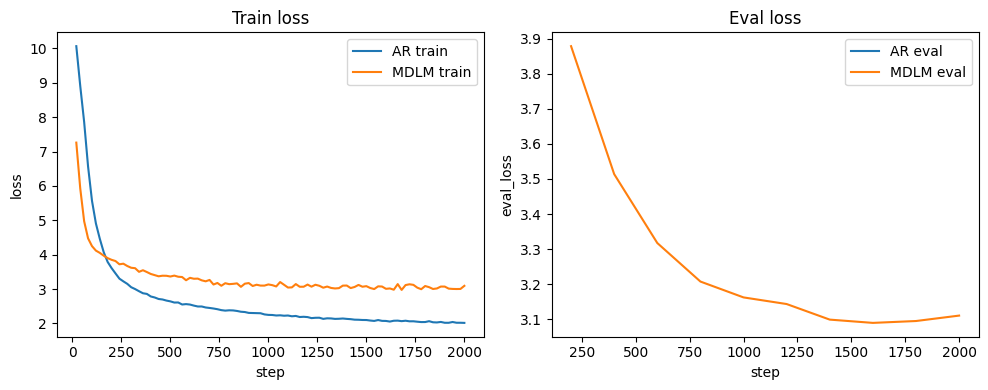

In [21]:
import matplotlib.pyplot as plt

def extract(log_history, key):
    xs, ys = [], []
    for r in log_history:
        if key in r and "step" in r:
            xs.append(r["step"])
            ys.append(r[key])
    return xs, ys

ar_train_x, ar_train_y = extract(trainer_ar.state.log_history, "loss")
ar_eval_x,  ar_eval_y  = extract(trainer_ar.state.log_history, "eval_loss")

m_train_x, m_train_y = extract(trainer_mdlm.state.log_history, "loss")
m_eval_x,  m_eval_y  = extract(trainer_mdlm.state.log_history, "eval_loss")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ar_train_x, ar_train_y, label="AR train")
plt.plot(m_train_x,  m_train_y,  label="MDLM train")
plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.title("Train loss")

plt.subplot(1,2,2)
plt.plot(ar_eval_x, ar_eval_y, label="AR eval")
plt.plot(m_eval_x,  m_eval_y,  label="MDLM eval")
plt.xlabel("step"); plt.ylabel("eval_loss"); plt.legend(); plt.title("Eval loss")
plt.tight_layout()
plt.show()

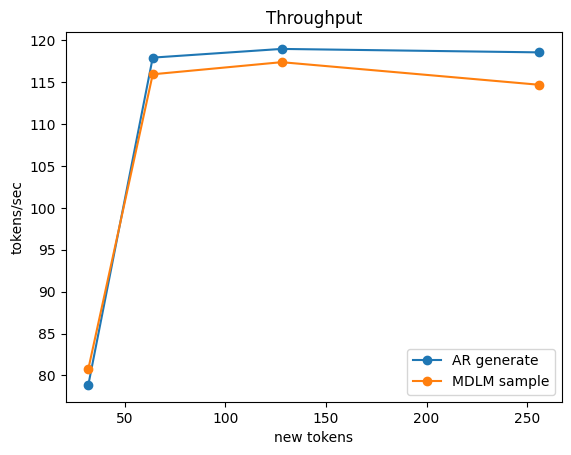

AR: [78.86411193229159, 117.92088483453941, 118.95787169757139, 118.54645035827522]
MDLM: [80.76700953009076, 115.93095331976953, 117.37636215007366, 114.67950787884924]


In [22]:
import time
import numpy as np

from dllm.core.samplers import MDLMSampler, MDLMSamplerConfig

prompt = "Once upon a time, in a small village,"
prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]

sampler = MDLMSampler(model=model_mdlm.eval(), tokenizer=tok_mdlm)

def bench_ar(max_new_tokens):
    torch.cuda.synchronize()
    t0 = time.time()
    _ = model_ar.eval().generate(
        torch.tensor([prompt_ids], device=model_ar.device),
        max_new_tokens=max_new_tokens,
        do_sample=False,
    )
    torch.cuda.synchronize()
    return max_new_tokens / (time.time() - t0)

def bench_mdlm(max_new_tokens, steps=128):
    cfg = MDLMSamplerConfig(max_new_tokens=max_new_tokens, steps=steps, block_size=256, temperature=0.0, return_dict=False)
    torch.cuda.synchronize()
    t0 = time.time()
    _ = sampler.sample([prompt_ids], cfg)
    torch.cuda.synchronize()
    return max_new_tokens / (time.time() - t0)

Ns = [32, 64, 128, 256]
ar_tps = [bench_ar(n) for n in Ns]
mdlm_tps = [bench_mdlm(n, steps=n) for n in Ns]  # steps≈tokens for fair-ish compare

import matplotlib.pyplot as plt
plt.plot(Ns, ar_tps, marker="o", label="AR generate")
plt.plot(Ns, mdlm_tps, marker="o", label="MDLM sample")
plt.xlabel("new tokens"); plt.ylabel("tokens/sec"); plt.legend(); plt.title("Throughput")
plt.show()

print("AR:", ar_tps)
print("MDLM:", mdlm_tps)